In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## 1. Data Loading


In [2]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import balanced_accuracy_score
from sklearn.svm import SVC
import xgboost
from sklearn.neural_network import MLPClassifier
from imblearn.over_sampling import SMOTE, SMOTEN
from sklearn.model_selection import GridSearchCV
from sklearn.calibration import CalibrationDisplay

In [3]:
# propublica_df = pd.read_csv('/content/drive/MyDrive/531project/propublica_data_for_fairml.csv')
propublica_df = pd.read_csv('/content/drive/MyDrive/DSCI531/propublica_data_for_fairml.csv')

In [4]:
propublica_df.head()

,Two_yr_Recidivism,Number_of_Priors,score_factor,Age_Above_FourtyFive,Age_Below_TwentyFive,African_American,Asian,Hispanic,Native_American,Other,Female,Misdemeanor
0,0,0,0,1,0,0,0,0,0,1,0,0
1,1,0,0,0,0,1,0,0,0,0,0,0
2,1,4,0,0,1,1,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,1,0,1
4,1,14,1,0,0,0,0,0,0,0,0,0


In [11]:
propublica_df.shape

(6172, 12)

In [16]:
propublica_df['Two_yr_Recidivism'].value_counts().reset_index()
# plt.pie([4997, 1175], labels=['Male', 'Female'], colors=sns.color_palette('dark'), autopct='%.0f%%')

,index,Two_yr_Recidivism
0,0,3363
1,1,2809


In [17]:
sm = SMOTEN(random_state=123)
y = propublica_df['Female']
X = propublica_df.drop('Female', axis=1)
X_smote, y_smote = sm.fit_resample(X, y)


In [20]:
y_smote

0       0
1       0
2       0
3       0
4       0
       ..
9989    1
9990    1
9991    1
9992    1
9993    1
Name: Female, Length: 9994, dtype: int64

([<matplotlib.patches.Wedge at 0x7f95797eab10>,
 [Text(6.735557395310444e-17, 1.1, 'Male'),
  Text(-2.0206672185931328e-16, -1.1, 'Female')],
 [Text(3.6739403974420595e-17, 0.6, '50%'),
  Text(-1.1021821192326178e-16, -0.6, '50%')])

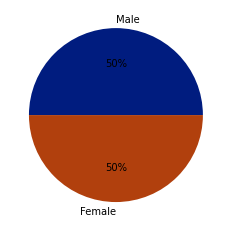

In [23]:
y_smote.value_counts().reset_index()
plt.pie([4997, 4997], labels=['Male', 'Female'], colors=sns.color_palette('dark'), autopct='%.0f%%')

In [5]:
propublica_df.columns

Index(['Two_yr_Recidivism', 'Number_of_Priors', 'score_factor',
       'Age_Above_FourtyFive', 'Age_Below_TwentyFive', 'African_American',
       'Asian', 'Hispanic', 'Native_American', 'Other', 'Female',
       'Misdemeanor'],
      dtype='object')

In [6]:
propublica_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6172 entries, 0 to 6171
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype
---  ------                --------------  -----
 0   Two_yr_Recidivism     6172 non-null   int64
 1   Number_of_Priors      6172 non-null   int64
 2   score_factor          6172 non-null   int64
 3   Age_Above_FourtyFive  6172 non-null   int64
 4   Age_Below_TwentyFive  6172 non-null   int64
 5   African_American      6172 non-null   int64
 6   Asian                 6172 non-null   int64
 7   Hispanic              6172 non-null   int64
 8   Native_American       6172 non-null   int64
 9   Other                 6172 non-null   int64
 10  Female                6172 non-null   int64
 11  Misdemeanor           6172 non-null   int64
dtypes: int64(12)
memory usage: 578.8 KB


In [7]:
# check missing values
propublica_df.isna().sum()

Two_yr_Recidivism       0
Number_of_Priors        0
score_factor            0
Age_Above_FourtyFive    0
Age_Below_TwentyFive    0
African_American        0
Asian                   0
Hispanic                0
Native_American         0
Other                   0
Female                  0
Misdemeanor             0
dtype: int64

## 2. DEA


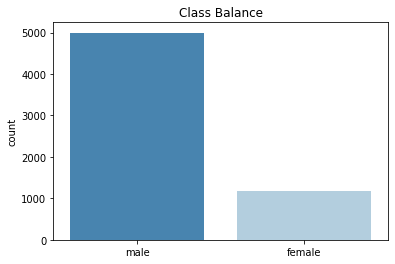

In [8]:
# check class balance
propublica_df['gender'] = propublica_df['Female'].apply(lambda x: 'female' if x == 1 else 'male')
sns.countplot(data=propublica_df, x='gender', palette="Blues_r")
plt.title("Class Balance")
plt.xlabel("")
plt.show(block=False)
propublica_df.drop(['gender'], axis=1, inplace = True)

In [9]:
age_sex = propublica_df[['Two_yr_Recidivism','Age_Above_FourtyFive', 'Age_Below_TwentyFive','Female', 'African_American']] 
age_sex['sex'] = np.where(age_sex['Female'] == 0, 'male', 'female')
conditions = [(age_sex['Age_Above_FourtyFive'] == 1), (age_sex['Age_Below_TwentyFive'] == 1), (age_sex['Age_Above_FourtyFive'] == 0) & (age_sex['Age_Below_TwentyFive'] == 0)]
values = ['>45', '<25', '25-45']
age_sex['age'] = np.select(conditions, values)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


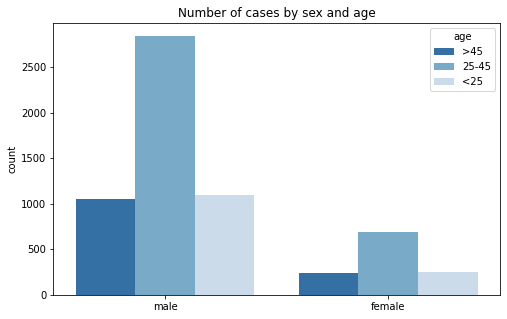

In [10]:
# This plot shows the age and sex distribution of the dataset
plt.figure(figsize=(8,5))
sns.countplot(data=age_sex,x="sex",hue="age",palette="Blues_r")
plt.title("Number of cases by sex and age")
plt.xlabel("")
plt.show(block=False)

Sex and Recidivism	

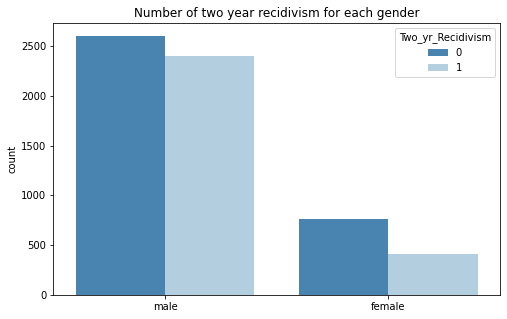

Male two year recidivism ratio:  0.48
Feale two year recidivism ratio:  0.35


In [11]:
# This plot shows the case number of two year recidivism for each gender
plt.figure(figsize=(8,5))
sns.countplot(data=age_sex,x="sex",hue="Two_yr_Recidivism",palette="Blues_r")
plt.title("Number of two year recidivism for each gender")
plt.xlabel("")
plt.show(block=False)

male_ratio = age_sex.loc[age_sex['sex'] == 'male', 'Two_yr_Recidivism'].sum()/len(age_sex.loc[age_sex['sex'] == 'male'])
female_ratio = age_sex.loc[age_sex['sex'] == 'female', 'Two_yr_Recidivism'].sum()/len(age_sex.loc[age_sex['sex'] == 'female'])

print('Male two year recidivism ratio: ', round(male_ratio, 2))
print('Feale two year recidivism ratio: ', round(female_ratio, 2))

In [12]:
# This chunk calculate the precentage of recidivism between age, sex.
column_order = ['<25', '25-45','>45']
table1 = pd.pivot_table(data=age_sex,index="sex",values="Two_yr_Recidivism",columns="age")
table2 = table1.reindex(column_order, axis=1)
table2

age,<25,25-45,>45
sex,,,
female,0.378049,0.378810,0.245833
male,0.600363,0.485403,0.337132


Race

In [13]:
# African American
black_only_df = age_sex[age_sex["African_American"] == 1]

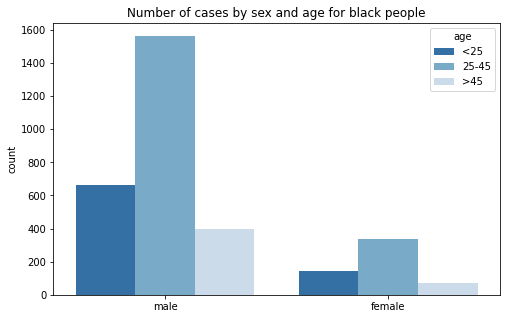

In [14]:
# This plot shows the age and sex distribution of the dataset
plt.figure(figsize=(8,5))
sns.countplot(data=black_only_df,x="sex",hue="age",palette="Blues_r", hue_order = ['<25', '25-45','>45'])
plt.title("Number of cases by sex and age for black people")
plt.xlabel("")
plt.show(block=False)

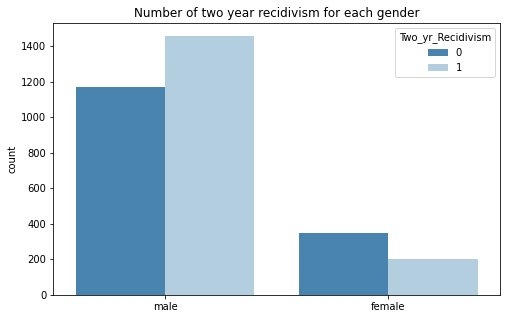

Male two year recidivism ratio:  0.56
Feale two year recidivism ratio:  0.37


In [15]:
# This plot shows the case number of two year recidivism for each gender for black people
plt.figure(figsize=(8,5))
sns.countplot(data=black_only_df,x="sex",hue="Two_yr_Recidivism",palette="Blues_r")
plt.title("Number of two year recidivism for each gender")
plt.xlabel("")
plt.show(block=False)

male_ratio = black_only_df.loc[black_only_df['sex'] == 'male', 'Two_yr_Recidivism'].sum()/len(black_only_df.loc[black_only_df['sex'] == 'male'])
female_ratio = black_only_df.loc[black_only_df['sex'] == 'female', 'Two_yr_Recidivism'].sum()/len(black_only_df.loc[black_only_df['sex'] == 'female'])

print('Male two year recidivism ratio: ', round(male_ratio, 2))
print('Feale two year recidivism ratio: ', round(female_ratio, 2))

In [16]:
# This chunk calculate the precentage of recidivism between age, sex for black people
column_order = ['<25', '25-45','>45']
table1 = pd.pivot_table(data=black_only_df,index="sex",values="Two_yr_Recidivism",columns="age")
table2 = table1.reindex(column_order, axis=1)
table2

age,<25,25-45,>45
sex,,,
female,0.441379,0.367164,0.231884
male,0.643072,0.547025,0.441103


## 3. Model Training

In [12]:
X_train, X_test, y_train, y_test = train_test_split(
    propublica_df.iloc[:, 1:], 
    propublica_df.iloc[:, 0], 
    test_size=0.3, 
    random_state=123)

Apply ML models to predict recidivism

In [18]:
# Logistics regression
lr = LogisticRegression(random_state=101, max_iter=300).fit(X_train, y_train)
lr_predict = lr.predict(X_test)
print('accuracy ==>', accuracy_score(y_test, lr_predict))
print('balanced accuracy ==>', balanced_accuracy_score(y_test, lr_predict))
print('precision ==>', precision_score(y_test, lr_predict))
print('recall ==>', recall_score(y_test, lr_predict))
print('f1 ==>', f1_score(y_test, lr_predict))

accuracy ==> 0.6808855291576674
balanced accuracy ==> 0.66780580139572
precision ==> 0.682370820668693
recall ==> 0.5403128760529483
f1 ==> 0.6030893216924111


In [19]:
# SVM
svm = SVC().fit(X_train, y_train)
svm_predict = svm.predict(X_test)
print('accuracy ==>', accuracy_score(y_test, svm_predict))
print('balanced accuracy ==>', balanced_accuracy_score(y_test, svm_predict))
print('precision ==>', precision_score(y_test, svm_predict))
print('recall ==>', recall_score(y_test, svm_predict))
print('f1 ==>', f1_score(y_test, svm_predict))

accuracy ==> 0.6798056155507559
balanced accuracy ==> 0.6639151819020781
precision ==> 0.6957236842105263
recall ==> 0.5090252707581228
f1 ==> 0.5879082696316887


In [20]:
# XGBoost
xgb = xgboost.XGBClassifier().fit(X_train, y_train)
xgb_predict = xgb.predict(X_test)
accuracy_score(y_test, xgb_predict)
print('accuracy ==>', accuracy_score(y_test, xgb_predict))
print('balanced accuracy ==>', balanced_accuracy_score(y_test, xgb_predict))
print('precision ==>', precision_score(y_test, xgb_predict))
print('recall ==>', recall_score(y_test, xgb_predict))
print('f1 ==>', f1_score(y_test, xgb_predict))

accuracy ==> 0.6900647948164147
balanced accuracy ==> 0.6793780666178719
precision ==> 0.6838340486409156
recall ==> 0.5752105896510229
f1 ==> 0.6248366013071895


In [21]:
# MLP
mlp = MLPClassifier(random_state=101, max_iter=300).fit(X_train, y_train)
mlp_predict = mlp.predict(X_test)
accuracy_score(y_test, mlp_predict)
print('accuracy ==>', accuracy_score(y_test, mlp_predict))
print('balanced accuracy ==>', balanced_accuracy_score(y_test, mlp_predict))
print('precision ==>', precision_score(y_test, mlp_predict))
print('recall ==>', recall_score(y_test, mlp_predict))
print('f1 ==>', f1_score(y_test, mlp_predict))

accuracy ==> 0.6857451403887689
balanced accuracy ==> 0.6754603388999483
precision ==> 0.6760961810466761
recall ==> 0.5752105896510229
f1 ==> 0.6215864759427828


## 4. SMOTE

In [22]:
sm = SMOTEN(random_state=123)
X_smote, y_smote = sm.fit_resample(X_train, y_train)

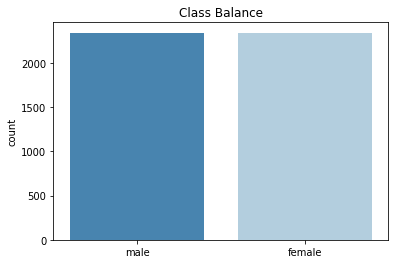

In [23]:
# check class imbalance
sns.barplot(data=y_smote.value_counts().reset_index(), x='index', y='Two_yr_Recidivism', palette="Blues_r")
plt.title("Class Balance")
plt.xlabel("")
plt.ylabel('count')
plt.xticks([0, 1],['0','0'])
plt.show(block=False)

In [24]:
# Logistics regression
lr_smote = LogisticRegression(random_state=101, max_iter=300).fit(X_smote, y_smote)
lr_predict_smote = lr_smote.predict(X_test)
print('accuracy ==>', accuracy_score(y_test, lr_predict_smote))
print('precision ==>', precision_score(y_test, lr_predict_smote))
print('recall ==>', recall_score(y_test, lr_predict_smote))
print('f1 ==>', f1_score(y_test, lr_predict_smote))

accuracy ==> 0.6771058315334774
precision ==> 0.6499356499356499
recall ==> 0.6077015643802648
f1 ==> 0.6281094527363184


In [25]:
# SVM
svm_smote = SVC().fit(X_smote, y_smote)
svm_predict_smote = svm_smote.predict(X_test)
print('accuracy ==>', accuracy_score(y_test, svm_predict_smote))
print('precision ==>', precision_score(y_test, svm_predict_smote))
print('recall ==>', recall_score(y_test, svm_predict_smote))
print('f1 ==>', f1_score(y_test, svm_predict_smote))

accuracy ==> 0.6684665226781857
precision ==> 0.629940119760479
recall ==> 0.6329723225030084
f1 ==> 0.631452581032413


In [26]:
# XGBoost
xgb_smote = xgboost.XGBClassifier().fit(X_smote, y_smote)
xgb_predict_smote = xgb_smote.predict(X_test)
print('accuracy ==>', accuracy_score(y_test, xgb_predict_smote))
print('precision ==>', precision_score(y_test, xgb_predict_smote))
print('recall ==>', recall_score(y_test, xgb_predict_smote))
print('f1 ==>', f1_score(y_test, xgb_predict_smote))

accuracy ==> 0.687365010799136
precision ==> 0.6684491978609626
recall ==> 0.601684717208183
f1 ==> 0.6333122229259025


In [27]:
# MLP
mlp_smote = MLPClassifier(random_state=101, max_iter=300).fit(X_smote, y_smote)
mlp_predict_smote = mlp_smote.predict(X_test)
print('accuracy ==>', accuracy_score(y_test, mlp_predict_smote))
print('precision ==>', precision_score(y_test, mlp_predict_smote))
print('recall ==>', recall_score(y_test, mlp_predict_smote))
print('f1 ==>', f1_score(y_test, mlp_predict_smote))

accuracy ==> 0.6954643628509719
precision ==> 0.6618181818181819
recall ==> 0.6570397111913358
f1 ==> 0.6594202898550725


## 5. Hyperparameter tuning on MLP

In [ ]:
parameters = {
  'hidden_layer_sizes': [100, 200, 300],
  'activation':['logistic', 'tanh', 'relu'],
  'alpha': [0.0001, 0.001, 0.01]
}
mlp_new = MLPClassifier(random_state=101, max_iter=500)

grid_search = GridSearchCV(
    estimator=mlp_new,
    param_grid=parameters,
    scoring = 'accuracy',
    cv = 5,
    verbose=2
)

grid_search.fit(X_smote, y_smote)

In [29]:
mlp_predict_gs = grid_search.best_estimator_.predict(X_test)
print('accuracy ==>', accuracy_score(y_test, mlp_predict_gs))
print('precision ==>', precision_score(y_test, mlp_predict_gs))
print('recall ==>', recall_score(y_test, mlp_predict_gs))
print('f1 ==>', f1_score(y_test, mlp_predict_gs))

accuracy ==> 0.6862850971922246
precision ==> 0.6453488372093024
recall ==> 0.6678700361010831
f1 ==> 0.6564163217031344


## 6. Fairness Analysis

Explore fairness in prediction result

In [30]:
def stat_parity(preds, sens):
    return sum(preds[sens == 1]) / sum(sens == 1) - sum(preds[sens == 0]) / sum(sens == 0)

def eq_oppo(preds, sens, labels):
    denom1, denom2 = sum(sens & labels), sum((sens == 0) & (labels == 1))
    if not denom1 and not denom2:
      return 0
    if not denom1:
      return 0 - sum(preds[(sens == 0) & (labels == 1)]) / denom2
    if not denom2:
      return sum(preds[(sens == 1) & (labels == 1)]) / denom1
    return (sum(preds[(sens == 1) & (labels == 1)]) / denom1) - (sum(preds[(sens == 0) & (labels == 1)]) / denom2)

In [31]:
mean_rec_male = y_train[X_train[X_train['Female'] == 0].index].sum() / X_train[X_train['Female'] == 0].shape[0]
mean_rec_female = y_train[X_train[X_train['Female'] == 1].index].sum() / X_train[X_train['Female'] == 1].shape[0]
print(mean_rec_male, mean_rec_female)

0.48028571428571426 0.3621951219512195


In [32]:
# stat parity & equal opportunity
stat_p = stat_parity(mlp_predict_smote, X_test['Female'])
eq_op = eq_oppo(mlp_predict_smote, X_test['Female'], y_test)
print(stat_p, eq_op)

-0.20609670044313977 -0.1524596093561611


remove sensitive feature (remove 'female' colum)

In [33]:
X_train_no_female = X_smote.drop(['Female'], axis=1)
y_train_no_female = y_smote[X_train_no_female.index]

X_test_no_female = X_test.drop(['Female'], axis=1)
y_test_no_female = y_test[X_test_no_female.index]

In [34]:
mlp_no_female = MLPClassifier(random_state=101, max_iter=300).fit(X_train_no_female, y_train_no_female)
mlp_predict_no_female = mlp_no_female.predict(X_test_no_female)
print('accuracy ==>', accuracy_score(y_test_no_female, mlp_predict_no_female))
print('precision ==>', precision_score(y_test_no_female, mlp_predict_no_female))
print('recall ==>', recall_score(y_test_no_female, mlp_predict_no_female))
print('f1 ==>', f1_score(y_test_no_female, mlp_predict_no_female))

accuracy ==> 0.6841252699784017
precision ==> 0.6492718446601942
recall ==> 0.6438026474127557
f1 ==> 0.6465256797583082


In [35]:
stat_p = stat_parity(mlp_predict_no_female, X_test['Female'])
eq_op = eq_oppo(mlp_predict_no_female, X_test['Female'], y_test)
print(stat_p, eq_op)

-0.09391176719636457 -0.016843501326260002


duplicate training dataset and flip gender

In [36]:
X_train_new = X_smote.copy()
y_train_new = y_smote.copy()

In [37]:
X_train_new['Female'] = X_train_new['Female'].apply(lambda x: 1 if x == 0 else 0)
X_train_aug = pd.concat([X_smote, X_train_new])
y_train_aug = pd.concat([y_smote, y_train_new])

In [38]:
mlp_aug = MLPClassifier(random_state=101, max_iter=300).fit(X_train_aug, y_train_aug)
mlp_predict_aug = mlp_aug.predict(X_test)
print('accuracy ==>', accuracy_score(y_test, mlp_predict_aug))
print('precision ==>', precision_score(y_test, mlp_predict_aug))
print('recall ==>', recall_score(y_test, mlp_predict_aug))
print('f1 ==>', f1_score(y_test, mlp_predict_aug))

accuracy ==> 0.6862850971922246
precision ==> 0.6550868486352357
recall ==> 0.6353790613718412
f1 ==> 0.6450824679291386


In [39]:
stat_p = stat_parity(mlp_predict_aug, X_test['Female'])
eq_op = eq_oppo(mlp_predict_aug, X_test['Female'], y_test)
print(stat_p, eq_op)

-0.1097669517438633 -0.037111164697371635


Calibration curve

In [60]:
y_prob = mlp_smote.predict_proba(X_test)[:, 1]

Text(0.5, 1.0, 'Calibration plots')

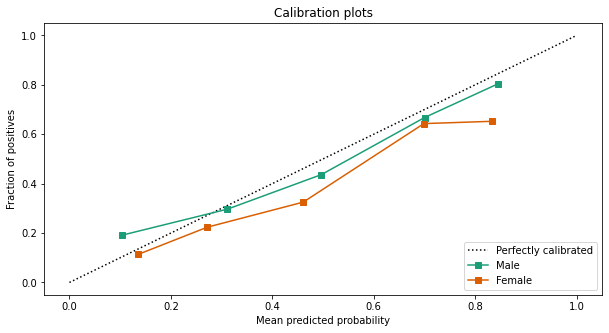

In [70]:
fig = plt.figure(figsize=(10, 5))
colors = plt.cm.get_cmap("Dark2")
ax_calibration_curve = fig.add_subplot()
CalibrationDisplay.from_predictions(y_test[X_test['Female'] == 0], y_prob[X_test['Female'] == 0], ax=ax_calibration_curve, color=colors(0), name='Male')
CalibrationDisplay.from_predictions(y_test[X_test['Female'] == 1], y_prob[X_test['Female'] == 1], ax=ax_calibration_curve, color=colors(1), name='Female')
ax_calibration_curve.set_title("Calibration plots")

In [86]:
def fnr(label, pred):
  return label[pred == 0].sum() / (label[pred == 0].sum() + label[pred == 1].sum())

print('Balance Error Rate for Male:', fnr(y_test[X_test['Female'] == 0], mlp_predict_smote[X_test['Female'] == 0]))
print('Balance Error Rate for Female:', fnr(y_test[X_test['Female'] == 1], mlp_predict_smote[X_test['Female'] == 1]))

Balance Error Rate for Male: 0.32167832167832167
Balance Error Rate for Female: 0.47413793103448276
